In [47]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


In [5]:
df_ori.shape

(7043, 16)

# Background

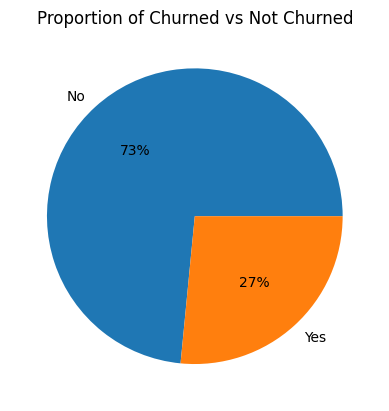

In [6]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [7]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

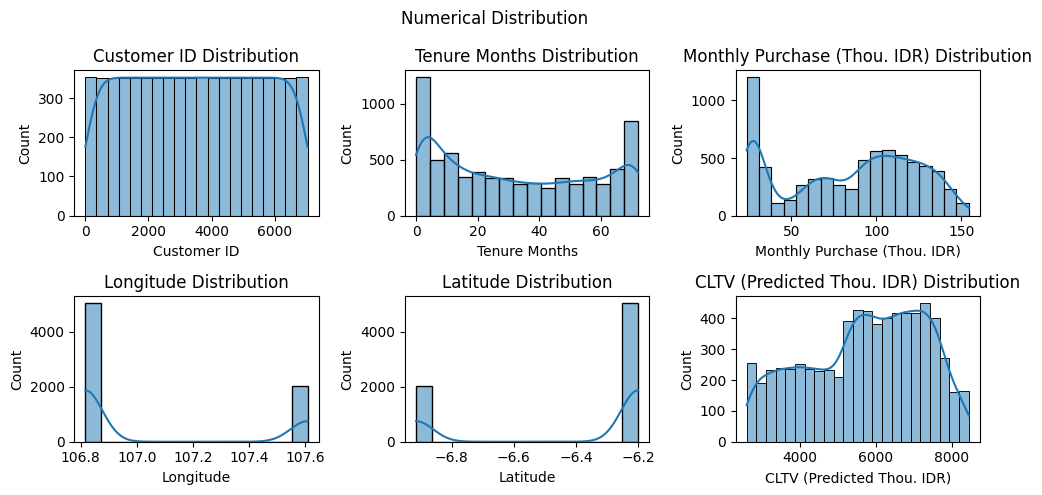

In [8]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.suptitle("Numerical Distribution")
fig.tight_layout()

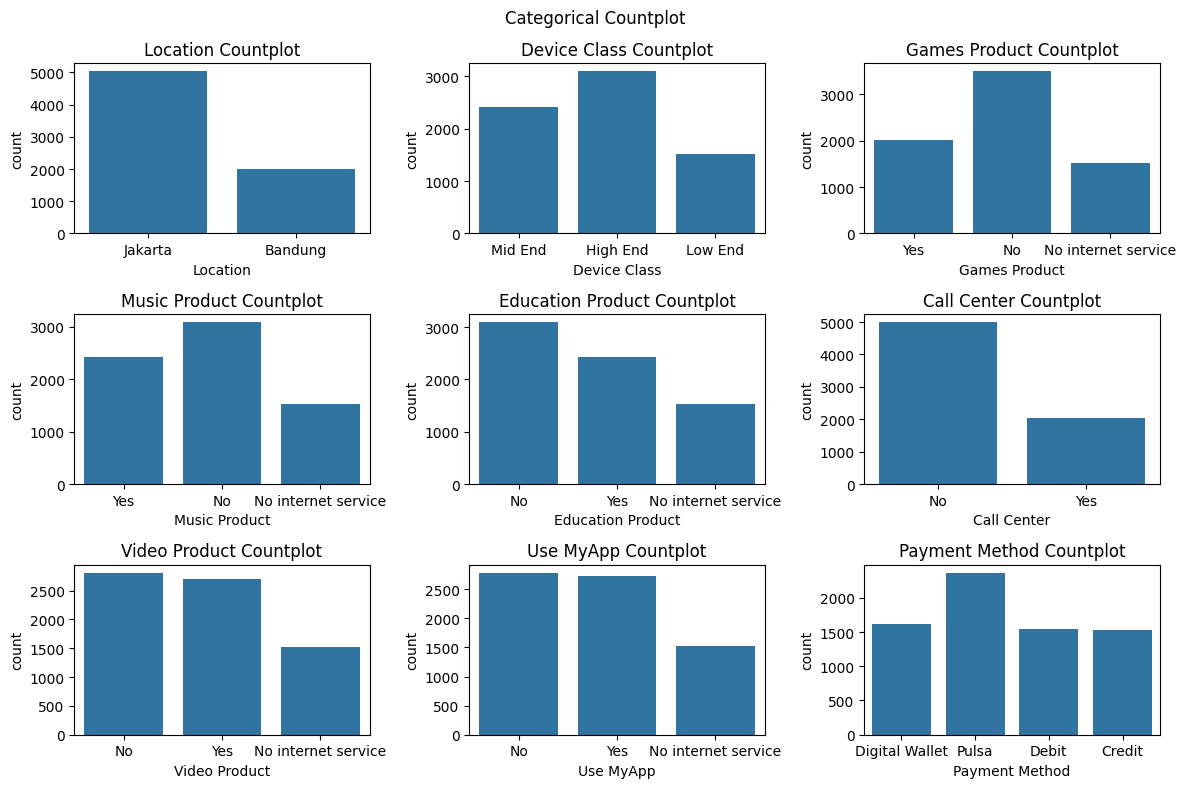

In [9]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.suptitle("Categorical Countplot")
fig.tight_layout()

### Hue `Churn Label`

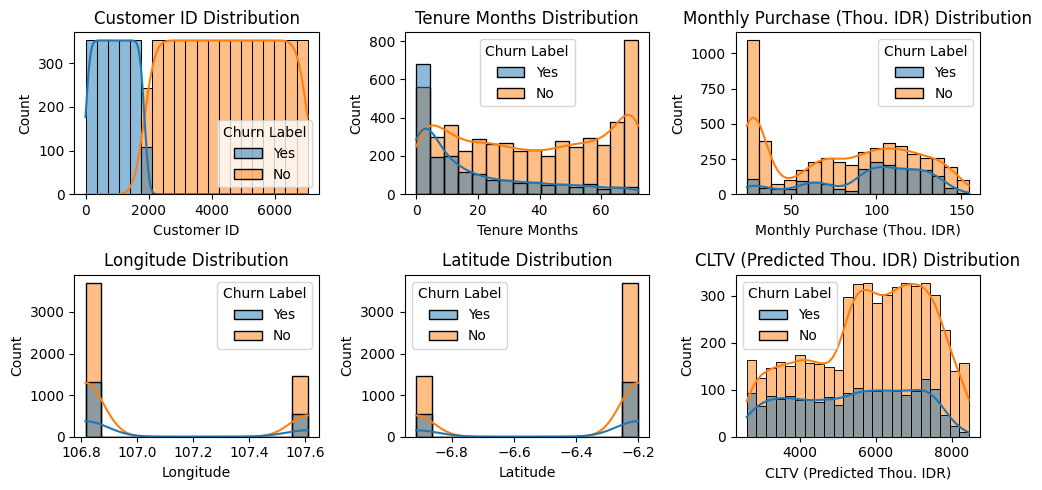

In [10]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

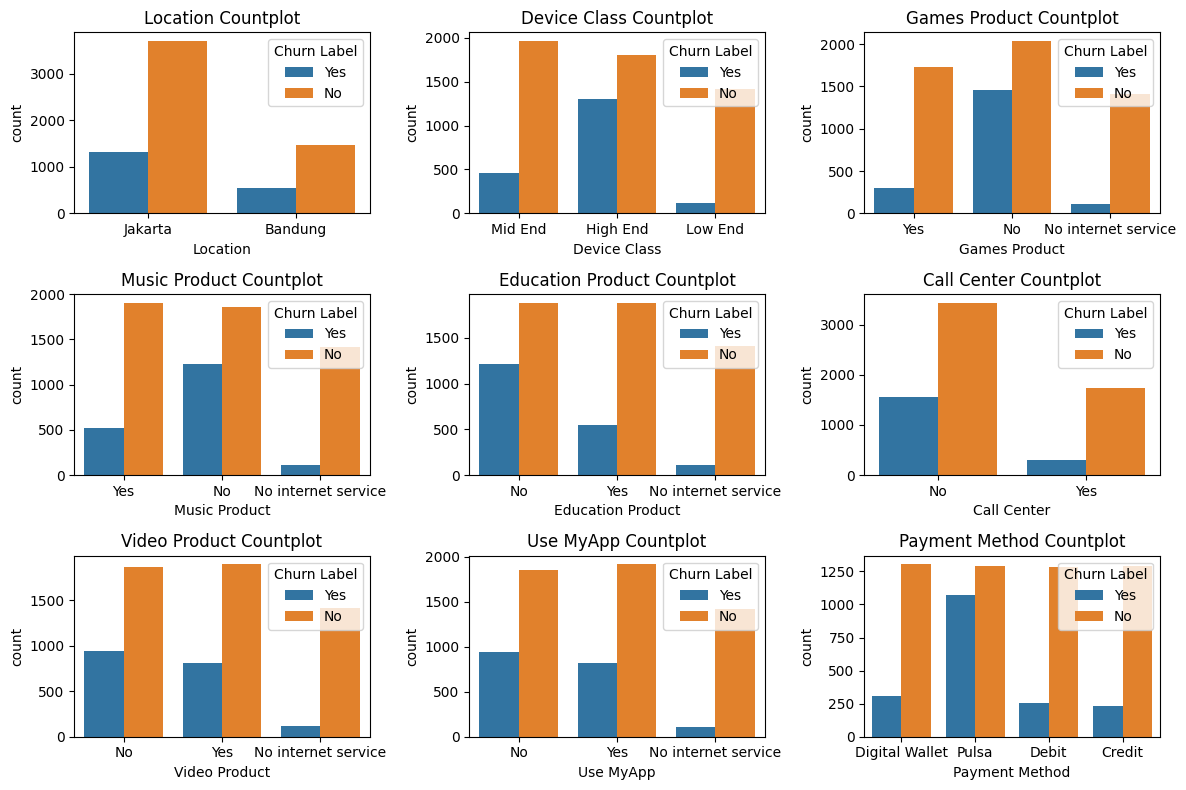

In [11]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [12]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [13]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

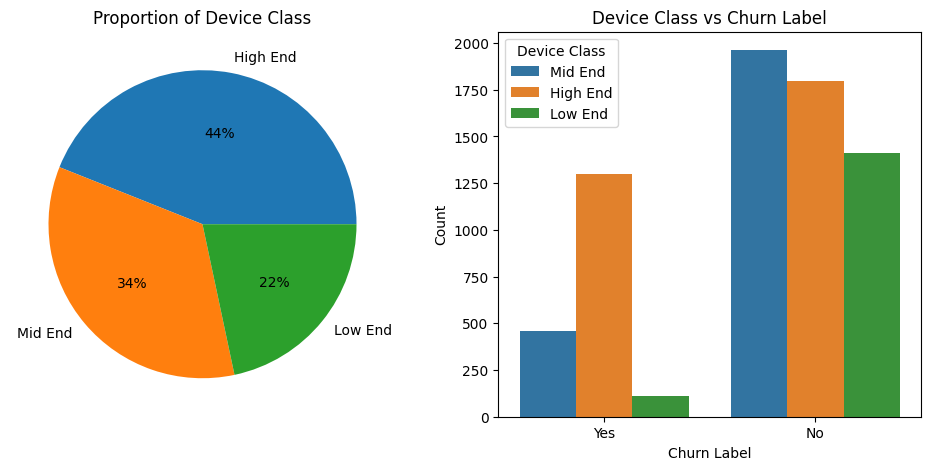

In [14]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

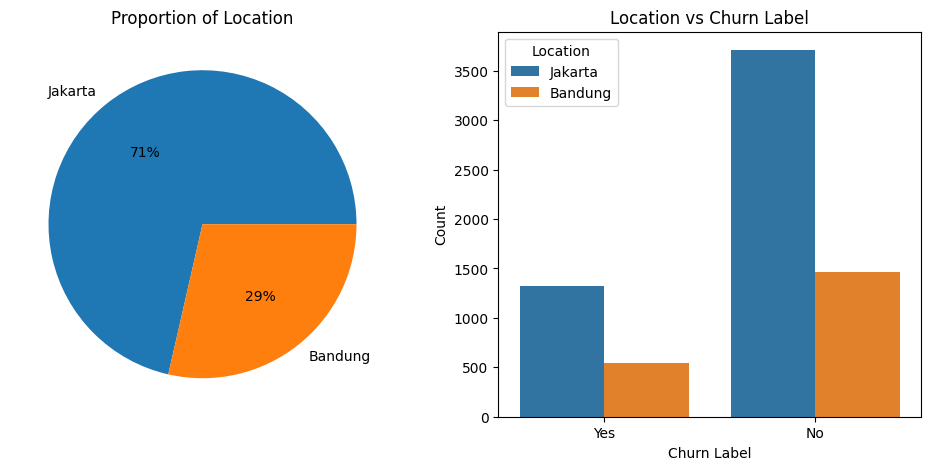

In [15]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [16]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [17]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    
    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

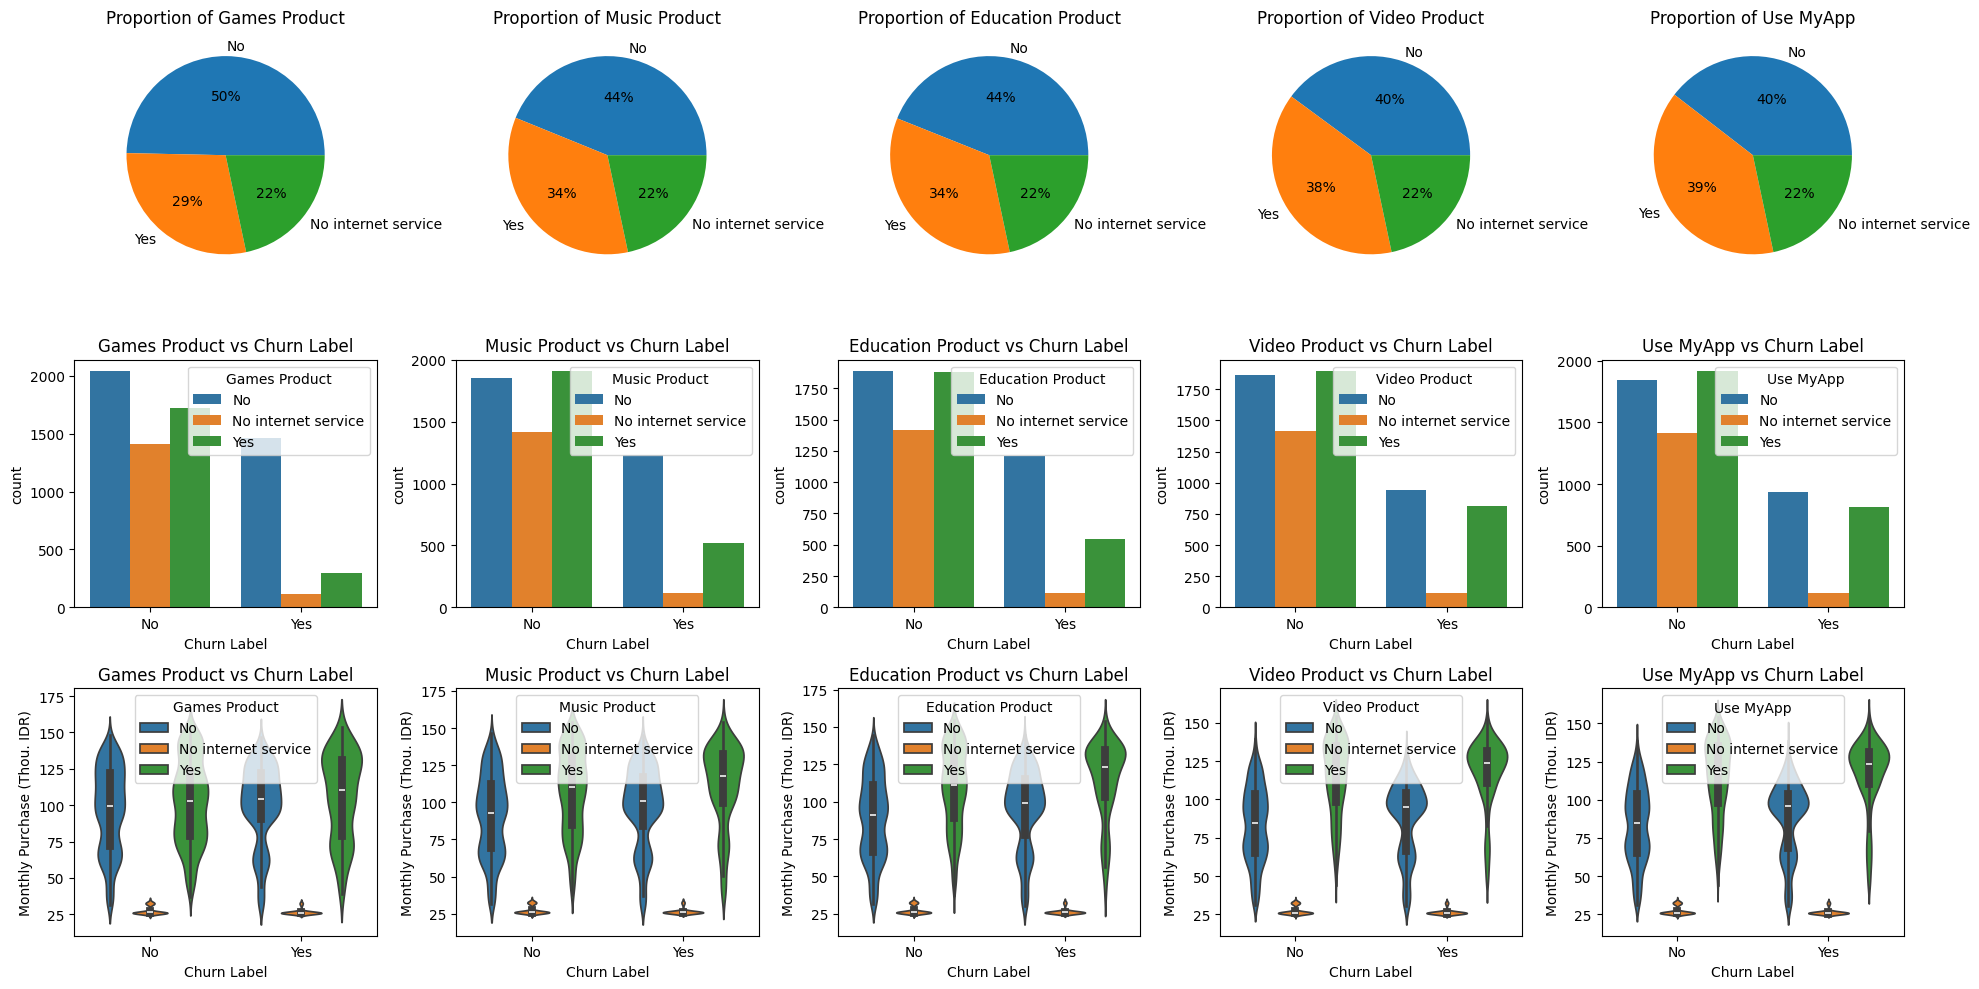

In [18]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

In [19]:
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

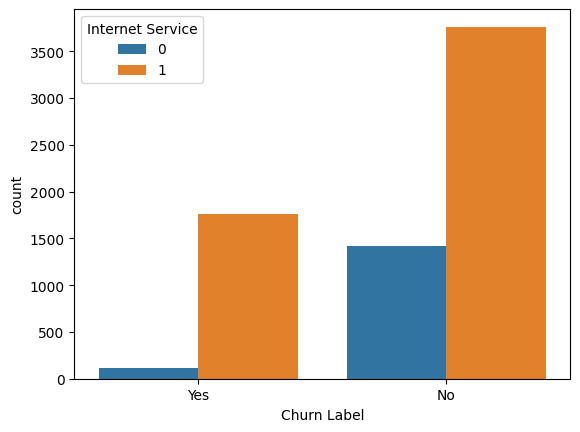

In [25]:
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
sns.countplot(data=df, x="Churn Label", hue="Internet Service")
# plt.title("Churn Label vs Internet Service")
plt.show()

## Payment Method

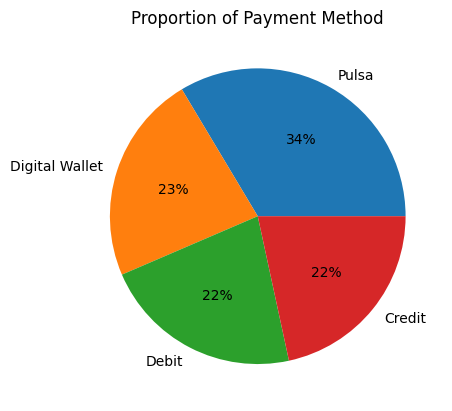

In [97]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

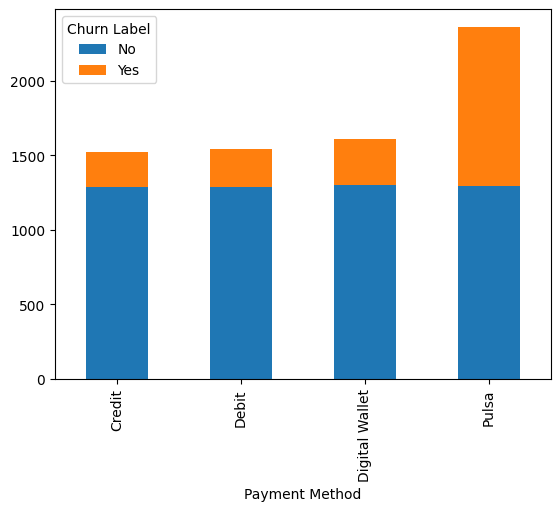

In [26]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
# plt.title("Payment Method vs Churn Label")
plt.show()

In [99]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [100]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


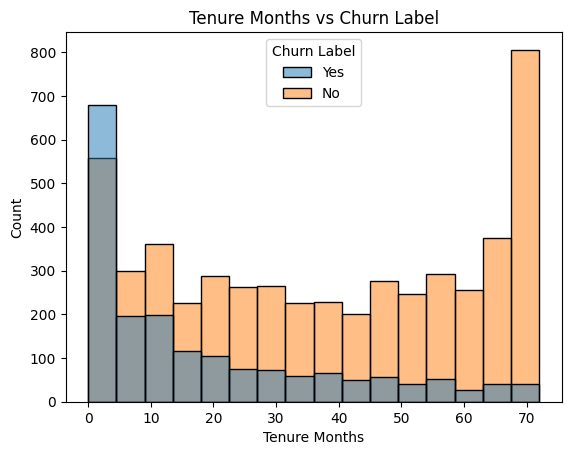

In [101]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

User with low tenure has a high change of churning especially from 0 to 10 months tenure

## Monthly Purchase

In [102]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

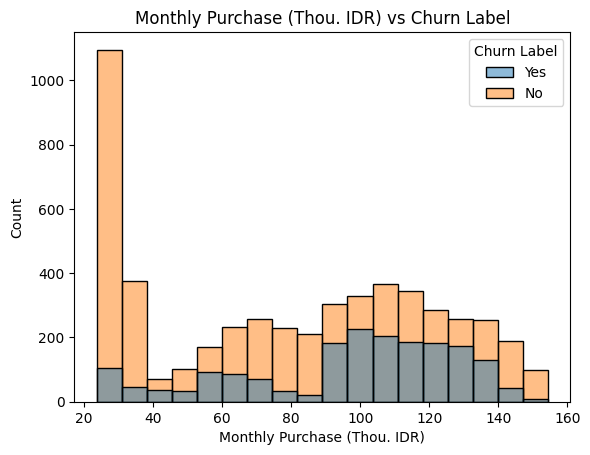

In [103]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

## CLTV

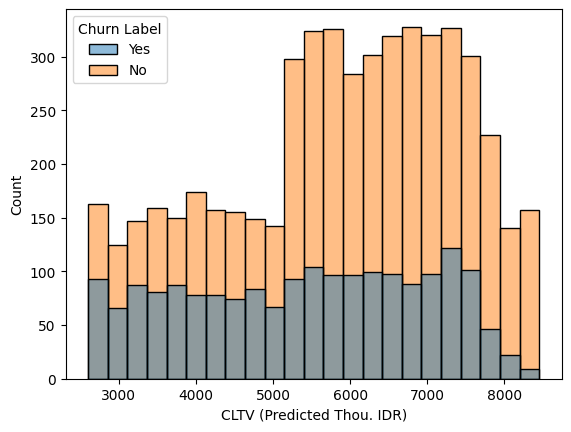

In [104]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

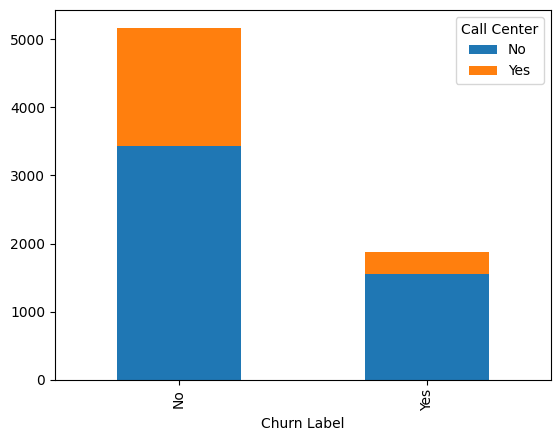

In [28]:
plot_df = df.pivot_table(index="Churn Label", columns="Call Center", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
# plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

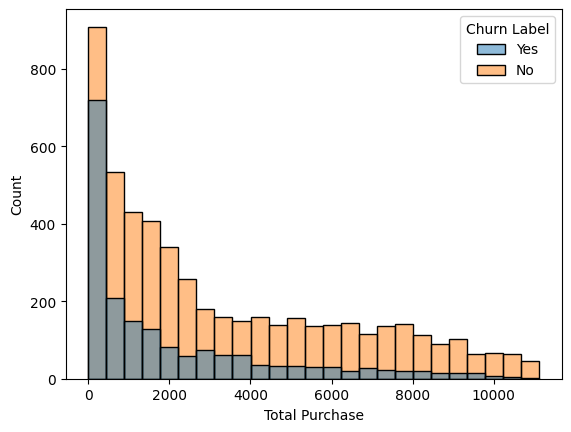

In [29]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
# plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

In [107]:
df

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Internet Service,Churn,Total Purchase
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,1,1,140.01
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,1,1,183.82
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,1,1,1036.36
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1,1,3814.72
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1,1,6605.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,72,Jakarta,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,27.495,No,106.816666,-6.2,6897.8,0,0,1979.64
7039,7039,24,Jakarta,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,110.240,No,106.816666,-6.2,2782.0,1,0,2645.76
7040,7040,72,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Credit,134.160,No,106.816666,-6.2,7228.0,1,0,9659.52
7041,7041,11,Jakarta,Mid End,Yes,No,No,No,No,No,Pulsa,38.480,No,106.816666,-6.2,3630.9,1,0,423.28


## Used Products

<function matplotlib.pyplot.show(close=None, block=None)>

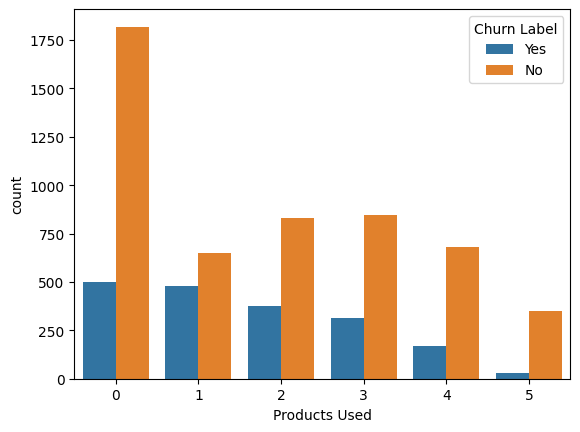

In [31]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
# plt.title("Products Used vs Churn")
plt.show

In [42]:
df["Products Used"].value_counts()

Products Used
0    2321
2    1205
3    1158
1    1129
4     854
5     376
Name: count, dtype: int64

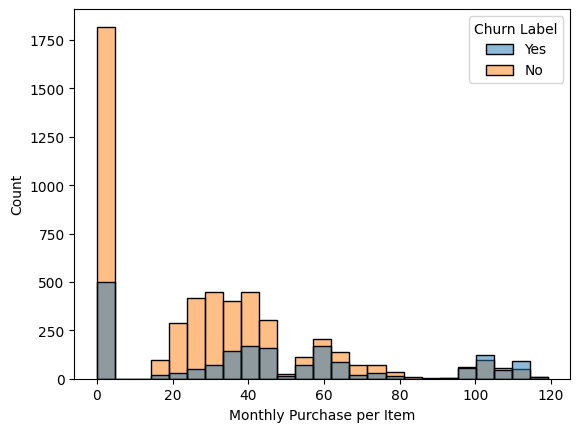

In [57]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"])
df["Monthly Purchase per Item"] = df["Monthly Purchase per Item"].replace(np.inf, 0)

sns.histplot(data=df, x="Monthly Purchase per Item", hue="Churn Label")
# plt.title("Monthly Purchase per Item vs Churn")
plt.show()

In [48]:
df["Monthly Purchase per Item"].replace(np.inf, 0)

0       35.002500
1        0.000000
2       43.181667
3       45.413333
4       33.702500
          ...    
7038     0.000000
7039    27.560000
7040    33.540000
7041    38.480000
7042    34.336250
Name: Monthly Purchase per Item, Length: 7043, dtype: float64

User that pay more and use little of the product services has a high chance of churning

# Correlation Map

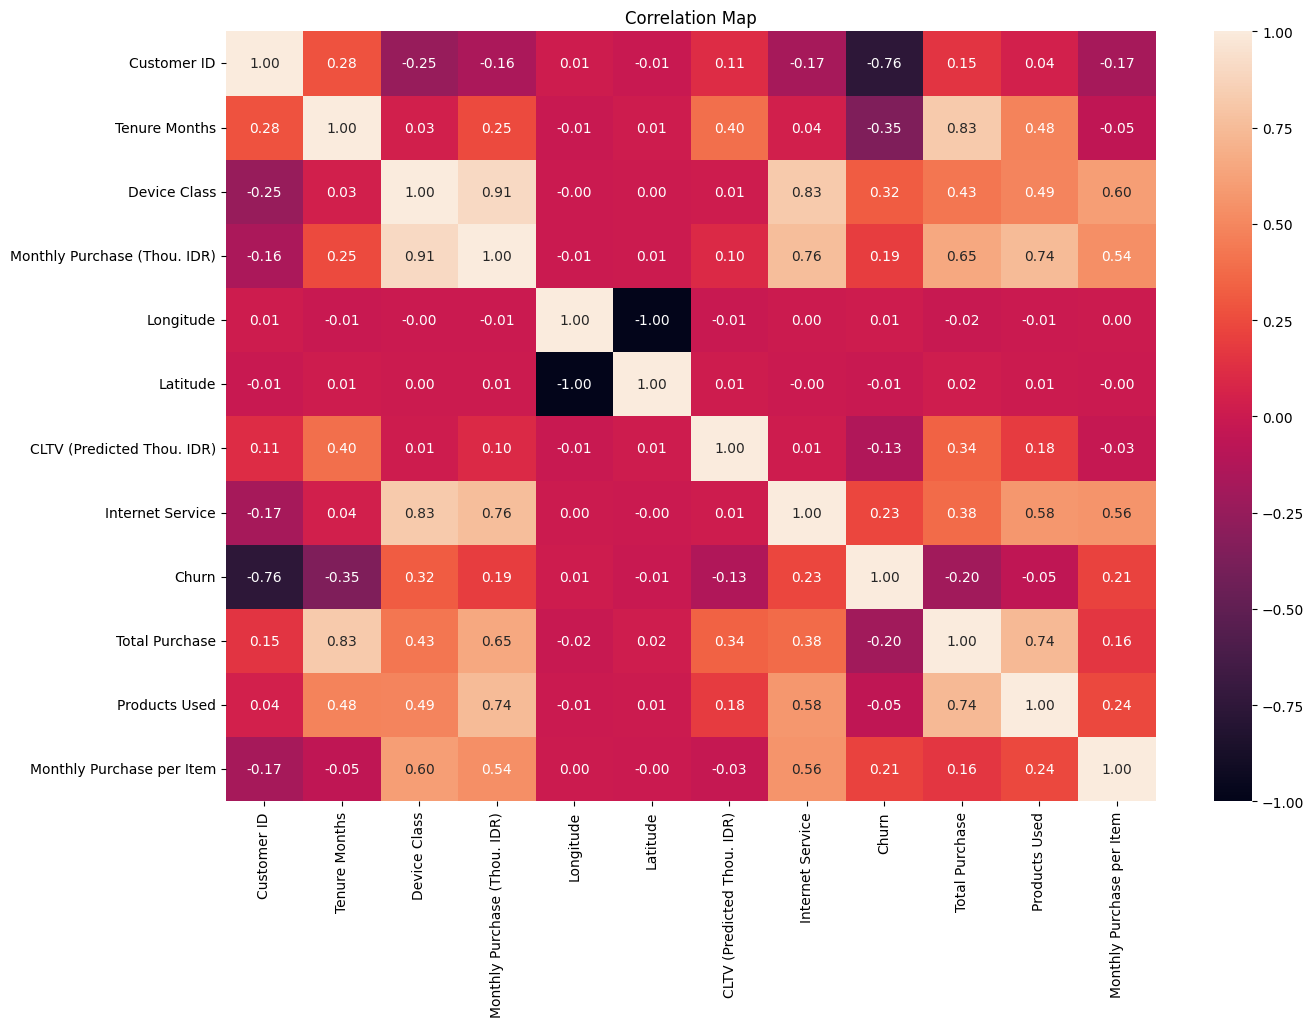

In [56]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [68]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score)
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score)
from sklearn.preprocessing import StandardScaler
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


# oversampling
from imblearn.over_sampling import (
    SMOTE, 
    SMOTENC,
    SVMSMOTE
)

# hyperparameter tuning
import optuna

In [59]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(f"Confusion Matrix of {model.__class__.__name__}")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

## Baseline Model
Select a simple logstic regression to get the feel about the base performance.

[0.83877014 0.85178251 0.82187808 0.84223781 0.8414744 ] 
Score Mean: 0.8392285880471135

    METRICS
    Accuracy: 0.7913413768630234
    Precision: 0.6333333333333333
    Recall: 0.5080213903743316
    F1 Score: 0.5637982195845698
    ROC AUC score: 0.7008705985688083
    Specificity: 0.893719806763285
    


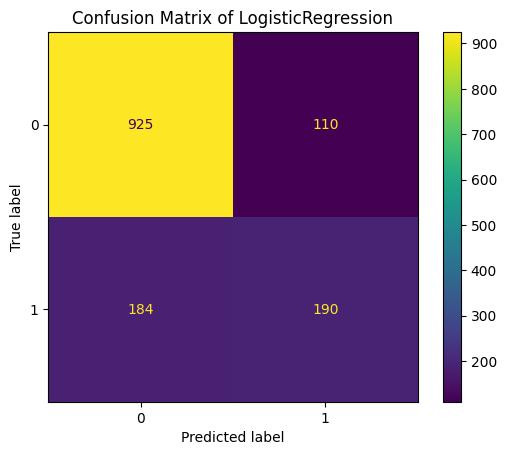

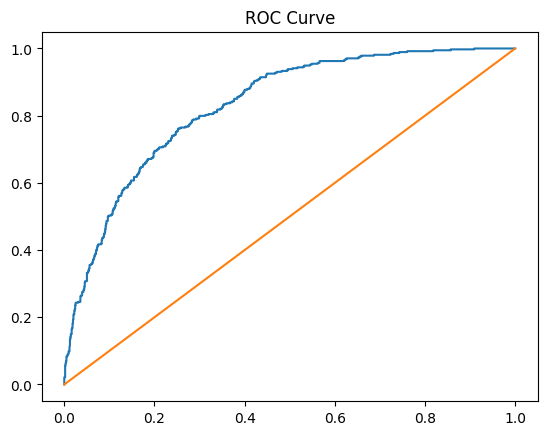

In [60]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Perfrom CV
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print(score, f"\nScore Mean: {score.mean()}")

# Train Logistic Regression
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Logistic Regression
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Feature Engineering

In [61]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

LogisticRegression
ROC AUC Scores: 0.8401798264747227,0.8527034559643254,0.8215630200507327,0.842532677362545,0.8418056161439904,0.8344501801496129,0.844933998998271,0.8342381206275346,0.8198423085001535,0.8417026158046952
ROC AUC Mean: 0.8373951820076584


    METRICS
    Accuracy: 0.794889992902768
    Precision: 0.6402640264026402
    Recall: 0.5187165775401069
    F1 Score: 0.5731166912850812
    ROC AUC score: 0.7067012839391356
    Specificity: 0.8946859903381642
    


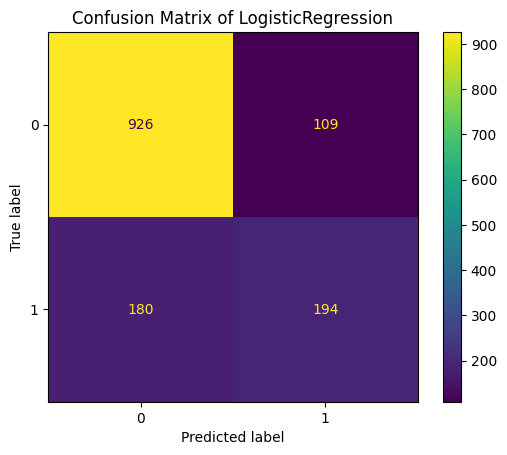

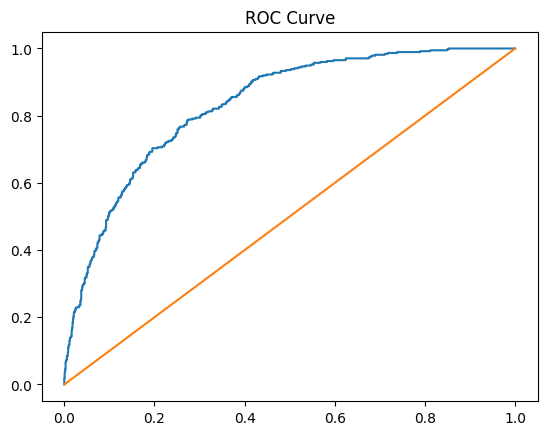

In [66]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=200)  # <<<<<<<<<<<<< DIFFERENT MODEL
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"""{model.__class__.__name__}
ROC AUC Scores: {','.join(roc_auc.astype(str))}
ROC AUC Mean: {roc_auc.mean()}
""")

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

### Perform Oversampling
Oversampling is used to tackle imbalance class problem.

SVMSMOTE

SVMSMOTE, LogisticRegression
ROC AUC Scores: 0.9228198149315038,0.9243608368923428,0.9150330229410255,0.931056588251768,0.9179196130598146,0.9202351571798644,0.9257968388993909,0.927221901327919,0.9207485880650659,0.9175184951807509
ROC AUC Mean: 0.9222710856729446


    METRICS
    Accuracy: 0.7814052519517388
    Precision: 0.5778301886792453
    Recall: 0.6550802139037433
    F1 Score: 0.6140350877192982
    ROC AUC score: 0.7410666770001808
    Specificity: 0.8270531400966183
    


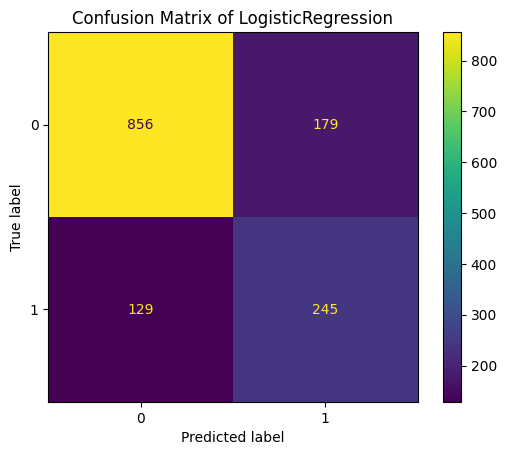

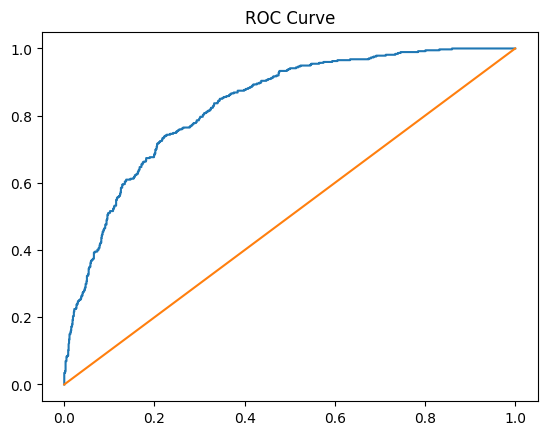

In [70]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.copy().drop(columns=["Churn Label"]), dtype=int), df.copy()["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling
# ========================================
oversampler = SVMSMOTE(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
    
# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=200)
cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

# Document The Result
# ========================================
print(f"""{oversampler.__class__.__name__}, {model.__class__.__name__}
ROC AUC Scores: {','.join(roc_auc.astype(str))}
ROC AUC Mean: {roc_auc.mean()}
""")

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Using oversampling we increase the the performance of the model based on ROC AUC. 

Note:

We have both categorical and continuous. SMOTENC is designed for that sepcific use case, but we limit the scope to SVMSMOTE only.

### Try Other Models

LogisticRegression done
SVC done
KNeighborsClassifier done
GaussianNB done
DecisionTreeClassifier done
RandomForestClassifier done
AdaBoostClassifier done
GradientBoostingClassifier done
XGBClassifier done
Learning rate set to 0.023094
0:	learn: 0.6796551	total: 123ms	remaining: 2m 2s
1:	learn: 0.6677962	total: 127ms	remaining: 1m 3s
2:	learn: 0.6534373	total: 131ms	remaining: 43.5s
3:	learn: 0.6405476	total: 135ms	remaining: 33.6s
4:	learn: 0.6285250	total: 139ms	remaining: 27.6s
5:	learn: 0.6157568	total: 144ms	remaining: 23.8s
6:	learn: 0.6048461	total: 148ms	remaining: 21s
7:	learn: 0.5967778	total: 152ms	remaining: 18.9s
8:	learn: 0.5880817	total: 157ms	remaining: 17.2s
9:	learn: 0.5787069	total: 161ms	remaining: 15.9s
10:	learn: 0.5700743	total: 165ms	remaining: 14.8s
11:	learn: 0.5611041	total: 169ms	remaining: 13.9s
12:	learn: 0.5539321	total: 174ms	remaining: 13.2s
13:	learn: 0.5458527	total: 178ms	remaining: 12.5s
14:	learn: 0.5388210	total: 182ms	remaining: 12s
15:	learn: 0.

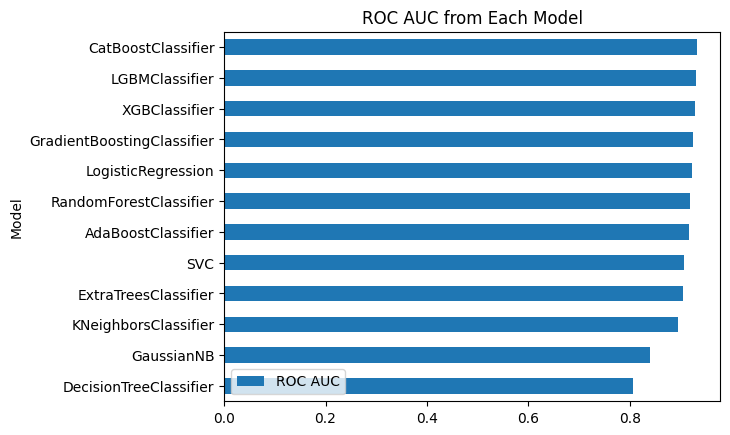

,ROC AUC
Model,
DecisionTreeClassifier,0.806018
GaussianNB,0.840810
KNeighborsClassifier,0.895377
ExtraTreesClassifier,0.904787
SVC,0.906686
AdaBoostClassifier,0.916879
RandomForestClassifier,0.919855
LogisticRegression,0.922271
GradientBoostingClassifier,0.924566


In [71]:
# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling
# ========================================
oversampler = SVMSMOTE(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

models = [
    LogisticRegression(random_state=42, max_iter=200),
    SVC(random_state=42),
    KNeighborsClassifier(), 
    GaussianNB(),
    DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), 
    xgb.XGBClassifier(random_state=42),
    cb.CatBoostClassifier(random_state=42), 
    lgb.LGBMClassifier(objective='binary', random_state=42), 
    ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []

for model in models:    
    # Cross Validation
    # ========================================
    cv = StratifiedShuffleSplit(n_splits=10,  test_size=0.2, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    roc_aucs.append(score.mean())
    print(f"{model.__class__.__name__} done")

    
df_model = pd.DataFrame(
    {
        "Model": [model.__class__.__name__ for model in models],
        "ROC AUC": roc_aucs,
    }
).set_index("Model").sort_values(by="ROC AUC")

# plot the f1 score comparison
df_model.plot.barh()
plt.title("ROC AUC from Each Model")
plt.legend(loc="lower left")
plt.show()
display(df_model)

Perform Hyperparameter Tuning on Top 5 Best models
1. GradientBoostingClassifier
2. RandomForestClassifier
3. XGBClassifier
4. LGBMClassifier
5. CatBoostClassifier

# Hyperparameter Tuning

In [ ]:
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]


In [89]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    df = df_ori.copy()
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
        .apply(lambda x: uses_internet_for_product(x["Games Product"])
            + uses_internet_for_product(x["Music Product"])
            + uses_internet_for_product(x["Education Product"])
            + uses_internet_for_product(x["Video Product"])
            + uses_internet_for_product(x["Use MyApp"]), axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
    df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ==============================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

    return (X_train, X_val, X_test, y_train, y_val, y_test)

## GradientBoosting

In [75]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, 50),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 256, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 100, 500),
    }

    # Cross validation
    # ==============================================
    model = GradientBoostingClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = GradientBoostingClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-08 20:53:55,507] A new study created in memory with name: no-name-d403ffe7-2079-44d4-9ea4-f76a1f48e125
[I 2023-11-08 20:54:01,337] Trial 0 finished with value: 0.7118090299072192 and parameters: {'learning_rate': 0.5013669498431504, 'n_estimators': 400, 'subsample': 0.8227999761455103, 'min_samples_split': 178, 'min_samples_leaf': 394}. Best is trial 0 with value: 0.7118090299072192.
[I 2023-11-08 20:54:04,038] Trial 1 finished with value: 0.7162310950439158 and parameters: {'learning_rate': 0.0008735076890628136, 'n_estimators': 400, 'subsample': 0.3651180512259047, 'min_samples_split': 92, 'min_samples_leaf': 473}. Best is trial 1 with value: 0.7162310950439158.
[I 2023-11-08 20:54:10,065] Trial 2 finished with value: 0.7424281548906317 and parameters: {'learning_rate': 0.00046208857455585253, 'n_estimators': 500, 'subsample': 0.6935238394586511, 'min_samples_split': 226, 'min_samples_leaf': 303}. Best is trial 2 with value: 0.7424281548906317.
[I 2023-11-08 20:54:10,607] 

Number of finished trials:  25
Best trial:
  Value: 0.7629174153334123
  Params: 
    learning_rate: 0.006309306683502273
    n_estimators: 100
    subsample: 0.9657503914664198
    min_samples_split: 24
    min_samples_leaf: 139

Recalls: 0.783
Precision: 0.518
F1 Score: 0.623
ROC AUC SCORE: 0.760



## Random Forest

In [76]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 200, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 200, 50),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, 50),
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_int("max_features", 1, len(X.columns)),
        "bootstrap": True
    }

    # Cross validation
    # ==============================================
    model = RandomForestClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-08 20:55:02,190] A new study created in memory with name: no-name-c2f779a1-238b-4126-95d7-6d3d8948db1d
[I 2023-11-08 20:55:08,682] Trial 0 finished with value: 0.7574077660501599 and parameters: {'max_depth': 8, 'min_samples_split': 200, 'min_samples_leaf': 200, 'n_estimators': 600, 'max_samples': 0.7, 'max_features': 13}. Best is trial 0 with value: 0.7574077660501599.
[I 2023-11-08 20:55:13,509] Trial 1 finished with value: 0.7612452435004967 and parameters: {'max_depth': 10, 'min_samples_split': 150, 'min_samples_leaf': 150, 'n_estimators': 450, 'max_samples': 0.7, 'max_features': 18}. Best is trial 1 with value: 0.7612452435004967.
[I 2023-11-08 20:55:15,008] Trial 2 finished with value: 0.7552065961575014 and parameters: {'max_depth': 4, 'min_samples_split': 50, 'min_samples_leaf': 200, 'n_estimators': 250, 'max_samples': 0.8, 'max_features': 11}. Best is trial 1 with value: 0.7612452435004967.
[I 2023-11-08 20:55:18,979] Trial 3 finished with value: 0.7529112825423468 

Number of finished trials:  25
Best trial:
  Value: 0.7621185386025126
  Params: 
    max_depth: 7
    min_samples_split: 150
    min_samples_leaf: 100
    n_estimators: 350
    max_samples: 0.5
    max_features: 13

Recalls: 0.717
Precision: 0.553
F1 Score: 0.624
ROC AUC SCORE: 0.753



## CatBoostClassifier

In [77]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Cross validation
    # ==============================================
    model = cb.CatBoostClassifier(**param, random_state=42)
    model.fit(X_train, y_train, verbose=0)
    preds = model.predict(X_val)
    y_pred = np.rint(preds)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train, verbose=0)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-08 20:56:43,522] A new study created in memory with name: no-name-f2df38e8-56c9-4e73-880d-907ff59dfb80
[I 2023-11-08 20:56:46,057] Trial 0 finished with value: 0.7471873442145542 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.038879023462452984, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7471873442145542.
[I 2023-11-08 20:56:56,291] Trial 1 finished with value: 0.7399571063268168 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06244435834258453, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.1389843902976982}. Best is trial 0 with value: 0.7471873442145542.
[I 2023-11-08 20:57:03,069] Trial 2 finished with value: 0.7431454403953678 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.023339833286630897, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24237645909681604}. Best is trial 0

Number of finished trials:  25
Best trial:
  Value: 0.7525409839005268
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.04412790906021697
    depth: 6
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.2989036769436784

Recalls: 0.652
Precision: 0.575
F1 Score: 0.612
ROC AUC SCORE: 0.739



## XGBClassifier

In [78]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)

# Transform data into DMatrix
# ==============================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Hyperparameter Tuning
# ==============================================
def objective(trial):

    # Hyperparameters
    # ==============================================
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 10, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    return roc_auc_score(y_val, pred_labels)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = xgb.XGBClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-08 20:59:46,183] A new study created in memory with name: no-name-fa63e36c-eee3-4b01-a142-154394eff434
[I 2023-11-08 20:59:46,206] Trial 0 finished with value: 0.7436941638064907 and parameters: {'booster': 'gblinear', 'lambda': 0.09648279716885602, 'alpha': 0.008031296582414678, 'subsample': 0.8640035068022602, 'colsample_bytree': 0.3143989948511287}. Best is trial 0 with value: 0.7436941638064907.
[I 2023-11-08 20:59:46,212] Trial 1 finished with value: 0.7431355777196776 and parameters: {'booster': 'gblinear', 'lambda': 0.0009160917395181871, 'alpha': 1.0304110368593206e-05, 'subsample': 0.39369831397213284, 'colsample_bytree': 0.3147012568907389}. Best is trial 0 with value: 0.7436941638064907.
[I 2023-11-08 20:59:46,228] Trial 2 finished with value: 0.7447458836778097 and parameters: {'booster': 'gblinear', 'lambda': 1.097430133385024e-06, 'alpha': 2.0778233405280533e-06, 'subsample': 0.2595064746929141, 'colsample_bytree': 0.7776071013146233}. Best is trial 2 with valu

Number of finished trials:  25
Best trial:
  Value: 0.7530215651886999
  Params: 
    booster: gbtree
    lambda: 8.374477125939987e-08
    alpha: 2.128917655892564e-07
    subsample: 0.342808225024298
    colsample_bytree: 0.6405625521131647
    max_depth: 10
    min_child_weight: 10
    eta: 1.3069371969583815e-07
    gamma: 0.9241634257989477
    grow_policy: depthwise

Recalls: 0.725
Precision: 0.536
F1 Score: 0.616
ROC AUC SCORE: 0.749



## LGBMClassifier

In [92]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200, 50),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    y_pred = np.rint(preds)
    return roc_auc_score(y_val, y_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = lgb.LGBMClassifier(**study.best_params, verbose=0, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-08 22:01:23,283] A new study created in memory with name: no-name-856981fe-dbab-4d6e-b02b-053521d3a2d1
[I 2023-11-08 22:01:23,385] Trial 0 finished with value: 0.7218053000225945 and parameters: {'lambda_l1': 0.003675315690218156, 'lambda_l2': 1.9401601998967842e-05, 'num_leaves': 225, 'feature_fraction': 0.9917109257360796, 'bagging_fraction': 0.6504725589476474, 'bagging_freq': 2, 'min_child_samples': 150}. Best is trial 0 with value: 0.7218053000225945.
[I 2023-11-08 22:01:23,523] Trial 1 finished with value: 0.7307659891905075 and parameters: {'lambda_l1': 2.6800434563639914e-08, 'lambda_l2': 3.635554566131793e-05, 'num_leaves': 106, 'feature_fraction': 0.5760116565871516, 'bagging_fraction': 0.7323386148886685, 'bagging_freq': 4, 'min_child_samples': 150}. Best is trial 1 with value: 0.7307659891905075.
[I 2023-11-08 22:01:23,627] Trial 2 finished with value: 0.7385610894132245 and parameters: {'lambda_l1': 6.054807675197643e-08, 'lambda_l2': 1.4246061637457991e-08, 'nu

Number of finished trials:  25
Best trial:
  Value: 0.7533461368795928
  Params: 
    lambda_l1: 8.131178127781492
    lambda_l2: 0.039487292600607446
    num_leaves: 181
    feature_fraction: 0.4509732249306284
    bagging_fraction: 0.9369012936355111
    bagging_freq: 1
    min_child_samples: 100
[LightGBM] [Warning] feature_fraction is set=0.4509732249306284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4509732249306284
[LightGBM] [Warning] lambda_l1 is set=8.131178127781492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.131178127781492
[LightGBM] [Warning] lambda_l2 is set=0.039487292600607446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039487292600607446
[LightGBM] [Warning] bagging_fraction is set=0.9369012936355111, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9369012936355111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] f

## Summarize
| No. | Model               | Recall | Precision | F1    | ROC AUC |
|-----|---------------------|--------|-----------|-------|---------|
| 1.  | GradientBoost       | 0.783  | 0.518     | 0.623 | 0.760   |
| 2.  | RandomForest        | 0.717  | 0.553     | 0.624 | 0.753   |
| 3.  | CatBoost            | 0.652  | 0.575     | 0.612 | 0.739   |
| 4.  | XGBoost             | 0.725  | 0.536     | 0.616 | 0.749   |
| 5.  | LGBM                | 0.660  | 0.574     | 0.614 | 0.742   |

Base on these model we want to be able to detect as many as churn users as possible, sacrificing a little bit of precision is okay. Predicting unchurned users as churn users doesn't bother use because they will be happy **(low chance of churning)** if we give approach with some retention strategy such as promotion, discount, etc.

# Inspect Models

In [96]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    df = df_ori.copy()
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
    df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
        .apply(lambda x: uses_internet_for_product(x["Games Product"])
            + uses_internet_for_product(x["Music Product"])
            + uses_internet_for_product(x["Education Product"])
            + uses_internet_for_product(x["Video Product"])
            + uses_internet_for_product(x["Use MyApp"]), axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
    df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data (tree model don't need for scaling)
    # ==============================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
    return X_train, X_test, y_train, y_test

In [97]:
pair_model_params = [
    (GradientBoostingClassifier,{
        "learning_rate": 0.006309306683502273,
        "n_estimators": 100,
        "subsample": 0.9657503914664198,
        "min_samples_split": 24,
        "min_samples_leaf": 139,
        "random_state": 42

    }),
    (RandomForestClassifier,{
        "max_depth": 7,
        "min_samples_split": 150,
        "min_samples_leaf": 100,
        "n_estimators": 350,
        "max_samples": 0.5,
        "max_features": 13,
        "random_state": 42

    }),
    (cb.CatBoostClassifier, {
        "objective": "CrossEntropy",
        "colsample_bylevel": 0.04412790906021697,
        "depth": 6,
        "boosting_type": "Ordered",
        "bootstrap_type": "Bernoulli",
        "subsample": 0.2989036769436784,
        "random_state": 42
    }),
    (xgb.XGBClassifier, {
        "booster": "gbtree",
        "lambda": 8.374477125939987e-08,
        "alpha": 2.128917655892564e-07,
        "subsample": 0.342808225024298,
        "colsample_bytree": 0.6405625521131647,
        "max_depth": 10,
        "min_child_weight": 10,
        "eta": 1.3069371969583815e-07,
        "gamma": 0.9241634257989477,
        "grow_policy": "depthwise",
        "random_state": 42
    }),
    (lgb.LGBMClassifier, {
        "lambda_l1": 8.131178127781492,
        "lambda_l2": 0.039487292600607446,
        "num_leaves": 181,
        "feature_fraction": 0.4509732249306284,
        "bagging_fraction": 0.9369012936355111,
        "bagging_freq": 1,
        "min_child_samples": 100,
        "random_state": 42
    })
]

In [98]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)
threshold = 0.5

recalls = []
precisions = []
f1s = []
roc_aucs = []
models = []
fig, ax = plt.subplots(ncols=len(pair_model_params), nrows=2, figsize=(30, 8))
for i, (model, params) in enumerate(pair_model_params):
    # Create Model and Predict
    # ============================================== 
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]

    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    models.append(model.__class__.__name__)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cmp.plot(ax=ax[0][i])
    ax[0][i].set_title(f"Confusion Matrix of {model.__class__.__name__}")

    # Stripplot plot
    sns.stripplot(x=y_pred_proba[:, 1], hue=y_test.tolist(), ax=ax[1][i], alpha=0.7)
    ax[1][i].set_title(f"Probability of Churning ({model.__class__.__name__})")
    ax[1][i].axvline(threshold, label="Threshold", color="red", linestyle="--")
    ax[1][i].set_xticks(np.arange(0, 1.001, 0.1))

fig.suptitle("Confusion Matrix and Strip Plot from Various Models")
fig.tight_layout()

In [238]:
pd.DataFrame({
    "Model": models,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1s,
    "ROC AUC": roc_aucs,
}).sort_values(by="ROC AUC", ascending=False)

,Model,Recall,Precision,F1 Score,ROC AUC
0,GradientBoostingClassifier,0.737968,0.536965,0.621622,0.754008
3,XGBClassifier,0.748663,0.526316,0.618102,0.752592
4,LGBMClassifier,0.713904,0.550515,0.621653,0.751638
1,RandomForestClassifier,0.727273,0.536489,0.617480,0.750110
2,CatBoostClassifier,0.727273,0.530214,0.613303,0.747211


ROC AUC score can be misleading, which are proven in the previous plot. LGBM overall is all Around Best Model having a high precision and adequate recall.

# Reconsideration
When it comes to presenting the results to the management, they want to be able to target actual churned customers that has high CLTV.

In [239]:
pair_model_params = [
    (GradientBoostingClassifier,{
        "learning_rate": 0.004168626628161481,
        "n_estimators": 300,
        "subsample": 0.421084339636955,
        "min_samples_split": 160,
        "min_samples_leaf": 169,
        "random_state": 42

    }),
    (RandomForestClassifier,{
        "max_depth": 5,
        "min_samples_split": 100,
        "min_samples_leaf": 50,
        "n_estimators": 400,
        "max_samples": 0.8,
        "max_features": 19,
        "random_state": 42

    }),
    (cb.CatBoostClassifier, {
        "objective": "Logloss",
        "colsample_bylevel": 0.019279784889392193,
        "depth": 11,
        "boosting_type": "Ordered",
        "bootstrap_type": "Bernoulli",
        "subsample": 0.3888083284876748,
        "random_state": 42
    }),
    (xgb.XGBClassifier, {
        "booster": "dart",
        "lambda": 3.0801253103282232e-06,
        "alpha": 1.3262277792817022e-06,
        "subsample": 0.5110951421384241,
        "colsample_bytree": 0.32513183823053105,
        "max_depth": 5,
        "min_child_weight": 8,
        "eta": 1.3731340344885955e-06,
        "gamma": 0.00030449033067205217,
        "grow_policy": "lossguide",
        "sample_type": "weighted",
        "normalize_type": "tree",
        "rate_drop": 1.9993069089328354e-06,
        "skip_drop": 0.016858563281265018,
        "random_state": 42
    }),
    (lgb.LGBMClassifier, {
        "lambda_l1": 4.9087660802805254e-08,
        "lambda_l2": 7.107814046559069e-08,
        "num_leaves": 3,
        "feature_fraction": 0.4386219301785611,
        "bagging_fraction": 0.5853318649736283,
        "bagging_freq": 1,
        "min_child_samples": 200,
        "random_state": 42
    })
]

Learning rate set to 0.025403
0:	learn: 0.6931472	total: 10.9ms	remaining: 10.9s
1:	learn: 0.6931472	total: 17.5ms	remaining: 8.74s
2:	learn: 0.6846571	total: 29.4ms	remaining: 9.77s
3:	learn: 0.6846571	total: 37.1ms	remaining: 9.24s
4:	learn: 0.6846571	total: 45.3ms	remaining: 9.01s
5:	learn: 0.6818575	total: 57.6ms	remaining: 9.55s
6:	learn: 0.6803650	total: 70ms	remaining: 9.93s
7:	learn: 0.6770728	total: 76.3ms	remaining: 9.46s
8:	learn: 0.6770728	total: 83ms	remaining: 9.14s
9:	learn: 0.6770727	total: 91.5ms	remaining: 9.05s
10:	learn: 0.6770727	total: 96.7ms	remaining: 8.69s
11:	learn: 0.6770727	total: 103ms	remaining: 8.51s
12:	learn: 0.6770727	total: 109ms	remaining: 8.25s
13:	learn: 0.6770727	total: 114ms	remaining: 8.03s
14:	learn: 0.6770727	total: 121ms	remaining: 7.96s
15:	learn: 0.6754352	total: 127ms	remaining: 7.81s
16:	learn: 0.6754352	total: 134ms	remaining: 7.73s
17:	learn: 0.6754352	total: 139ms	remaining: 7.59s
18:	learn: 0.6754352	total: 144ms	remaining: 7.46s
19:	

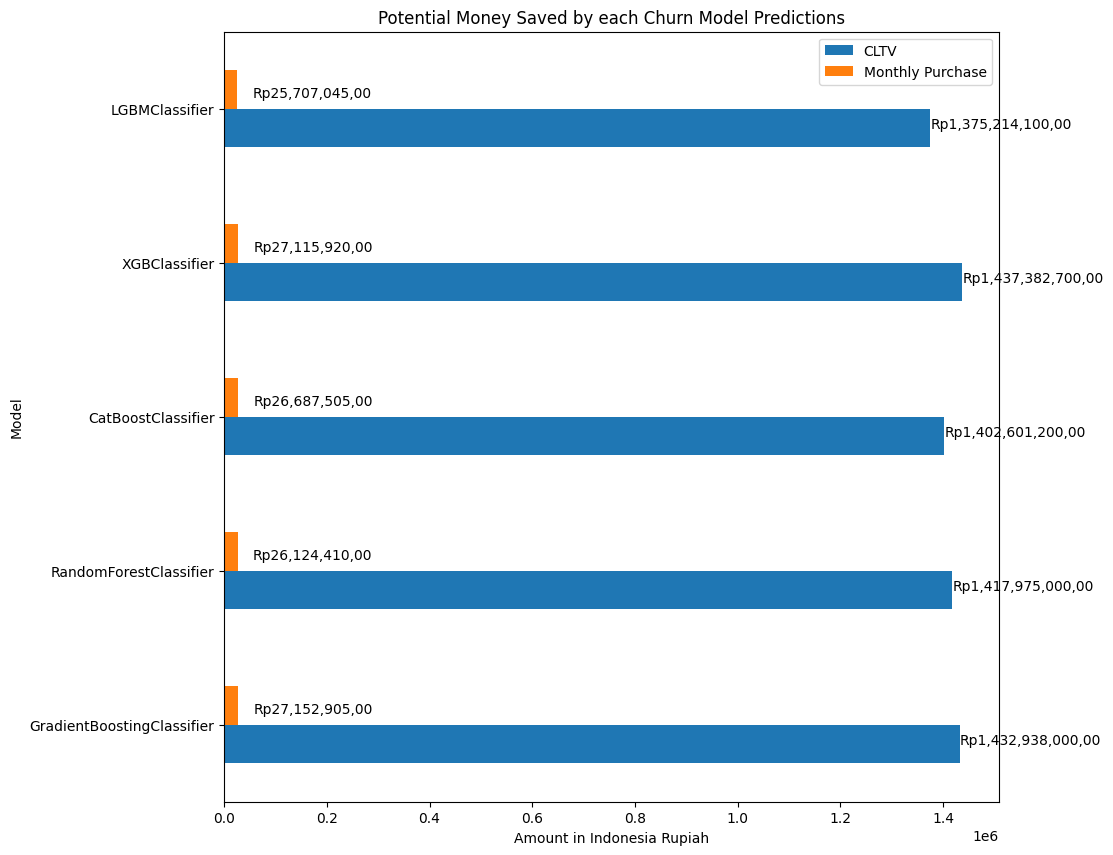

In [240]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)

models = []
cltvs = []
monthly_purchase = []
for (model, params) in pair_model_params:
    # Create Best Model
    # ==============================================
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict using threshold 0.5
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:,1]]

    # Calculate CLTV
    # ==============================================
    df = df_ori.copy()
    potentially_saved_money = df.iloc[y_test[(y_pred == y_test) & (y_test==1)].index, -1].sum()
    models.append(model.__class__.__name__)
    cltvs.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "CLTV (Predicted Thou. IDR)"].sum())
    monthly_purchase.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "Monthly Purchase (Thou. IDR)"].sum())

ax = pd.DataFrame({    
    "Model": models,
    "CLTV": cltvs,
    "Monthly Purchase": monthly_purchase,
    }).set_index("Model").plot.barh(figsize=(10, 10))

# Adding annotations to the bars
for i, v in enumerate(cltvs):
    ax.text(v + 3, i-0.1, f"Rp{v*1000:,.0f},00", va='center')

for i, v in enumerate(monthly_purchase):
    ax.text(v + 3 * 10000, i+0.1, f"Rp{v*1000:,.0f},00", color='black', va='center')

plt.xlabel("Amount in Indonesia Rupiah")
plt.title("Potential Money Saved by each Churn Model Predictions")
plt.show()